In [1]:
import pandas as pd
import json
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
def fetch_bitstamp_ohlc(pair='btcusd', step=86400, start_date='2018-01-01', end_date='2024-11-05'):
    """
    Fetches historical OHLC data from Bitstamp.

    Parameters:
    - pair (str): Currency pair (default is 'btcusd').
    - step (int): Time interval in seconds (default is 86400 for daily data).
    - start_date (str): Start date in 'YYYY-MM-DD' format.
    - end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
    - DataFrame: Pandas DataFrame containing the OHLC data.
    
    """
    base_url = 'https://www.bitstamp.net/api/v2/ohlc/'
    url = f"{base_url}{pair}/"

    # Convert dates to Unix timestamps
    start_timestamp = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp())
    end_timestamp = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp())

    params = {
        'step': step,
        'start': start_timestamp,
        'end': end_timestamp,
        'limit': 1000  # Maximum number of data points per request
    }

    all_data = []

    while start_timestamp < end_timestamp:
        response = requests.get(url, params=params)
        data = response.json()

        if 'data' in data and 'ohlc' in data['data']:
            ohlc_data = data['data']['ohlc']
            if not ohlc_data:
                break

            all_data.extend(ohlc_data)

            # Update start_timestamp to the timestamp of the last fetched data point
            last_timestamp = int(ohlc_data[-1]['timestamp'])
            start_timestamp = last_timestamp + step
            params['start'] = start_timestamp
        else:
            break

    # Convert to DataFrame
    df = pd.DataFrame(all_data)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df.set_index('timestamp', inplace=True)
    df = df.astype(float)

    return df
df = fetch_bitstamp_ohlc()
df = df.reset_index().rename(columns={'timestamp': 'date'})
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')
df['close_pct'] = df['close'].pct_change() * 100
df.dropna(inplace=True)
df.head()

,date,open,high,low,close,volume,close_pct
1,2022-02-11,43540.15,43969.72,41983.12,42406.19,2170.372397,-2.569604
2,2022-02-12,42392.22,43034.00,41740.06,42241.11,892.345330,-0.389283
3,2022-02-13,42232.68,42779.60,41882.54,42077.74,515.455742,-0.386756
4,2022-02-14,42078.53,42871.68,41575.00,42540.30,1270.886517,1.099299
5,2022-02-15,42567.27,44785.66,42469.96,44582.48,1772.923258,4.800577


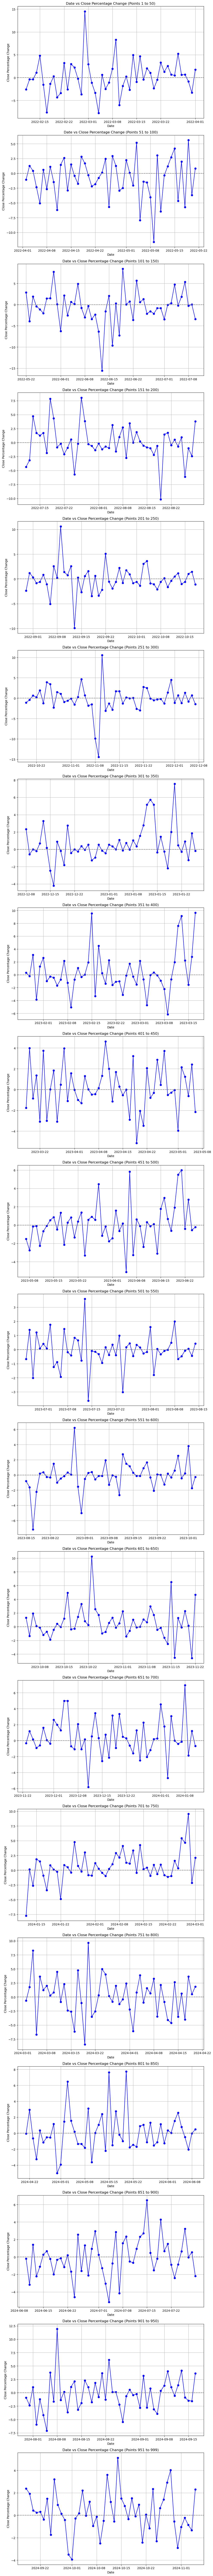

In [3]:
points_per_plot = 50
num_plots = len(df) // points_per_plot + (1 if len(df) % points_per_plot else 0)

# Plot each segment in a separate subplot
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6 * num_plots))

for i in range(num_plots):
    start = i * points_per_plot
    end = start + points_per_plot
    segment = df.iloc[start:end]
    
    ax = axes[i] if num_plots > 1 else axes  # Handle single subplot case
    ax.plot(segment['date'], segment['close_pct'], marker='o', linestyle='-', color='b')
    ax.axhline(y=0, color='gray', linestyle='--')  # Add horizontal line at 0
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Percentage Change')
    ax.set_title(f'Date vs Close Percentage Change (Points {start + 1} to {min(end, len(df))})')
    ax.grid()

plt.tight_layout()
plt.show()

In [105]:
df.tail()

,date,open,high,low,close,volume,close_pct,yes_close_pct,signal,square_off,prev_close_pct
995,2024-11-01,70202.0,71596.0,68768.0,69490.0,2717.471793,-1.055090,-2.903319,0,0,-2.903319
996,2024-11-02,69468.0,69887.0,69015.0,69330.0,1047.124687,-0.230249,-1.055090,0,0,-1.055090
997,2024-11-03,69339.0,69354.0,67459.0,68738.0,1915.471573,-0.853887,-0.230249,-1,0,-0.230249
998,2024-11-04,68738.0,69444.0,66798.0,67818.0,2538.340802,-1.338415,-0.853887,-1,0,-0.853887
999,2024-11-05,67817.0,70538.0,67443.0,69386.0,2370.705183,2.312071,-1.338415,1,0,-1.338415


In [9]:
df['prev_close_pct'] = df['close_pct'].shift(1)

df['signal'] = 0  # 0: No position, 1: Buy, -1: Sell
df['square_off'] = 0  # 1 if square off

df.loc[(df['close_pct'] > 0) & 
       (df['close_pct'] > df['prev_close_pct']) &
       (df['signal']==0), 'signal'] = 1
df.loc[(df['close_pct'] < 0) & 
       (df['close_pct'] < df['prev_close_pct']) &
       (df['signal']==0), 'signal'] = -1

df.loc[(df['signal'] == 1) & 
       (df['close_pct'] < df['prev_close_pct']), 'square_off'] = -1
df.loc[(df['signal'] == -1) & 
       (df['close_pct'] > df['prev_close_pct']), 'square_off'] = 1
df.dropna(inplace=True)

In [10]:
df.head()

,date,open,high,low,close,volume,close_pct,yes_close_pct,signal,square_off,prev_close_pct
2,2022-02-12,42392.22,43034.00,41740.06,42241.11,892.345330,-0.389283,-2.569604,0,0,-2.569604
3,2022-02-13,42232.68,42779.60,41882.54,42077.74,515.455742,-0.386756,-0.389283,0,0,-0.389283
4,2022-02-14,42078.53,42871.68,41575.00,42540.30,1270.886517,1.099299,-0.386756,1,0,-0.386756
5,2022-02-15,42567.27,44785.66,42469.96,44582.48,1772.923258,4.800577,1.099299,1,0,1.099299
6,2022-02-16,44590.75,44590.75,43312.83,43901.48,1251.833594,-1.527506,4.800577,-1,0,4.800577


In [110]:
signal = 0
pnl = 0
pnl_list = {}
entry_price = 0

sl_p_pct = 0.057

for i, row in df.iterrows():
    if row['date'] < pd.to_datetime('2022-06-01'):
        continue
    
    if signal == 0 and row['close_pct'] > 0 and row['close_pct'] > row['prev_close_pct']:
        signal = 1
        entry_price = row['close']
    elif signal == 0 and row['close_pct'] < 0 and row['close_pct'] < row['prev_close_pct']:
        signal = -1
        entry_price = row['close']
    
#     elif signal == 1 and row['close_pct'] < row['prev_close_pct']:
#         signal = 0
#         pnl_trade = (row['close'] - entry_price)
#         pnl += pnl_trade
#         pnl_list[row['date']] = pnl
    
#     elif signal == -1 and row['close_pct'] > row['prev_close_pct']:
#         signal = 0
#         pnl_trade = (entry_price - row['close'])
#         pnl += pnl_trade
#         pnl_list[row['date']] = pnl
        
    ## SL
    elif signal == 1 and row['low'] < (entry_price - entry_price*sl_p_pct):
        signal = 0
        pnl_trade = - (entry_price*0.05)
        pnl += pnl_trade
        pnl_list[row['date']] = pnl
    
    elif signal == -1 and row['high'] > (entry_price + entry_price*sl_p_pct):
        signal = 0
        pnl_trade = -(entry_price*0.05)
        pnl += pnl_trade
        pnl_list[row['date']] = pnl
        
    ## profit
    elif signal == 1 and row['high'] > (entry_price + entry_price*sl_p_pct):
        signal = 0
        pnl_trade =  (entry_price*0.05)
        pnl += pnl_trade
        pnl_list[row['date']] = pnl
    
    elif signal == -1 and row['low'] < (entry_price - entry_price*sl_p_pct):
        signal = 0
        pnl_trade = (entry_price*0.05)
        pnl += pnl_trade
        pnl_list[row['date']] = pnl

In [111]:
pnl

6555.110000000004

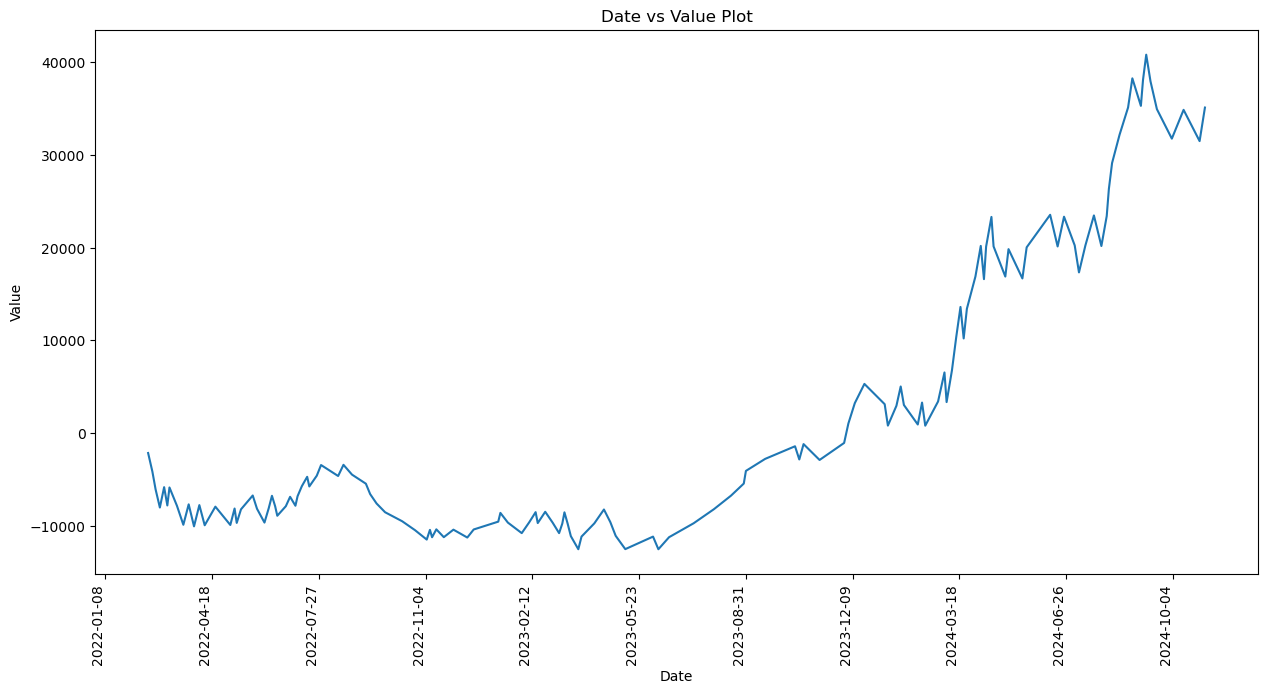

In [102]:
pnl_df = pd.DataFrame(list(pnl_list.items()), columns=['Date', 'Value'])
pnl_df.set_index('Date', inplace=True)

plt.figure(figsize=(15, 8))
pnl_df['Value'].plot()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Date vs Value Plot')
plt.xticks(rotation=90)

# Optional: Set the frequency of x-axis ticks to show all dates if necessary
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(len(pnl_df) // 10))

# for i in range(0, len(pnl_df), 20):
#     plt.axvline(x=pnl_df.index[i], color='gray', linestyle='--', linewidth=0.5)
    
plt.show()

In [104]:
pnl_df['pct'] = pnl_df['Value'].pct_change() * 100
for i in pnl_df['Value']:
    print(i)

-2127.0150000000003
-4132.466
-6045.963000000001
-8003.296000000001
-5806.460000000001
-7777.299500000001
-5839.617000000001
-7811.839500000001
-9860.000500000002
-7658.701000000002
-10031.652500000002
-7740.638500000002
-9913.365000000002
-7908.492000000002
-9881.862000000003
-8108.689000000003
-9658.687500000004
-8196.747000000003
-6705.124500000003
-8134.598500000003
-9623.968500000003
-8068.1775000000025
-6738.922500000002
-7866.686000000002
-8888.721000000003
-7861.080000000004
-6848.013000000004
-7809.986500000004
-6782.614000000003
-5703.407000000003
-4691.789500000003
-5731.882000000002
-4571.455500000002
-3423.0035000000016
-4605.232500000002
-3399.732500000002
-4457.032500000002
-5434.882500000002
-6554.932500000003
-7566.582500000002
-8510.482500000002
-9481.132500000002
-10440.1825
-11454.9825
-10409.6325
-11203.4825
-10353.1325
-11196.8325
-10386.9825
-11235.8325
-10367.7325
-9522.8325
-8580.1825
-9624.4325
-10760.282500000001
-9593.782500000001
-8500.382500000002
-9676.43

In [14]:
df.shape

(998, 11)

In [15]:
998/365

2.734246575342466

In [77]:
998

6.916666666666667